# Simulate both drift and start point biases

from Leite & Ratcliff (2011) -- What cognitive processes drive response biases? A diffusion model analysis:

"In the diffusion model, there are two ways to model response bias (Ratcliff, 1985; Ratcliff et al., 1999; Ratcliff & McKoon, 2008). One, analogous to the change in criterion threshold in SDT, involves a shift in the criterion that separates positive from negative drift rates. That is, one parameter (referred to as a “drift criterion” parameter, “dc”) produces an estimate of the amount to be added to or subtracted from the mean drift rates between conditions such that a null mean drift rate (a horizontal line starting at z in Figure 1.1) in an unbiased condition would be shifted to a positive or negative mean drift rate in a biased condition, for example. For small to moderate biases in drift rates, there are only small changes in the leading edges of the RT distributions between biased and unbiased conditions. The other way to model response bias involves moving the starting point of the diffusion process nearer the boundary toward which the responses are biased (Figure 1.1). This predicts a shorter leading edge of the RT distribution in the biased condition than in the unbiased condition (Ratcliff, 1985, 2002)."

Can we replicate this?

In [1]:
from __future__ import division
import numpy as np
from scipy import integrate
import pandas
import hddm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import math
import re

/Users/janwillem/anaconda/envs/v1/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/janwillem/anaconda/envs/v1/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
v = 0.8
a = 2.0
t = 1
z = 0.5
sz = 0
st = 0
sv = 0

drift_biases = [-0.0, -0.1, -0.2, -0.3, -0.4]
startpoint_biases = [-0.0, -0.05, -0.10, -0.15, -0.20]

In [3]:
parameters = []
conditions = []
for drift_bias, start_point_bias in itertools.product(drift_biases, startpoint_biases):
    # print drift_bias, start_point_bias
    conditions.append('biased.drift.%s.z.%s' % (drift_bias, start_point_bias))
    parameters.append({'v':v+drift_bias, 'a':a, 't':t,'sv':sv, 'z':z+start_point_bias, 'sz': sz, 'st': st})
    conditions.append('anti-biased.drift.%s.z.%s' % (drift_bias, start_point_bias))
    parameters.append({'v':v-drift_bias, 'a':a, 't':t,'sv':sv, 'z':z-start_point_bias, 'sz': sz, 'st': st})
    

In [4]:
df, params = hddm.generate.gen_rand_data(dict(zip(conditions, parameters)), size=10000, subjs=1)

In [5]:
reg = re.compile('(?P<bias>[a-z_-]+).drift.(?P<drift_bias>.*).z.(?P<start_point_bias>.*)')
df['bias_direction'] = df['condition'].apply(lambda x: reg.match(x).group('bias'))
df['drift_bias'] = df['condition'].apply(lambda x: reg.match(x).group('drift_bias'))
df['start_point_bias'] = df['condition'].apply(lambda x: reg.match(x).group('start_point_bias'))

In [6]:
def get_choice(row):
    if row.bias_direction == 'biased':
        if row.response == 1:
            return 'biased_option'
        else:
            return 'anti-biased option'
    elif row.bias_direction == 'anti-biased':
        if row.response == 0:
            return 'biased_option'
        else:
            return 'anti-biased option' 
df['bias_response'] = df.apply(get_choice, 1)

/Users/janwillem/anaconda/envs/v1/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 3)

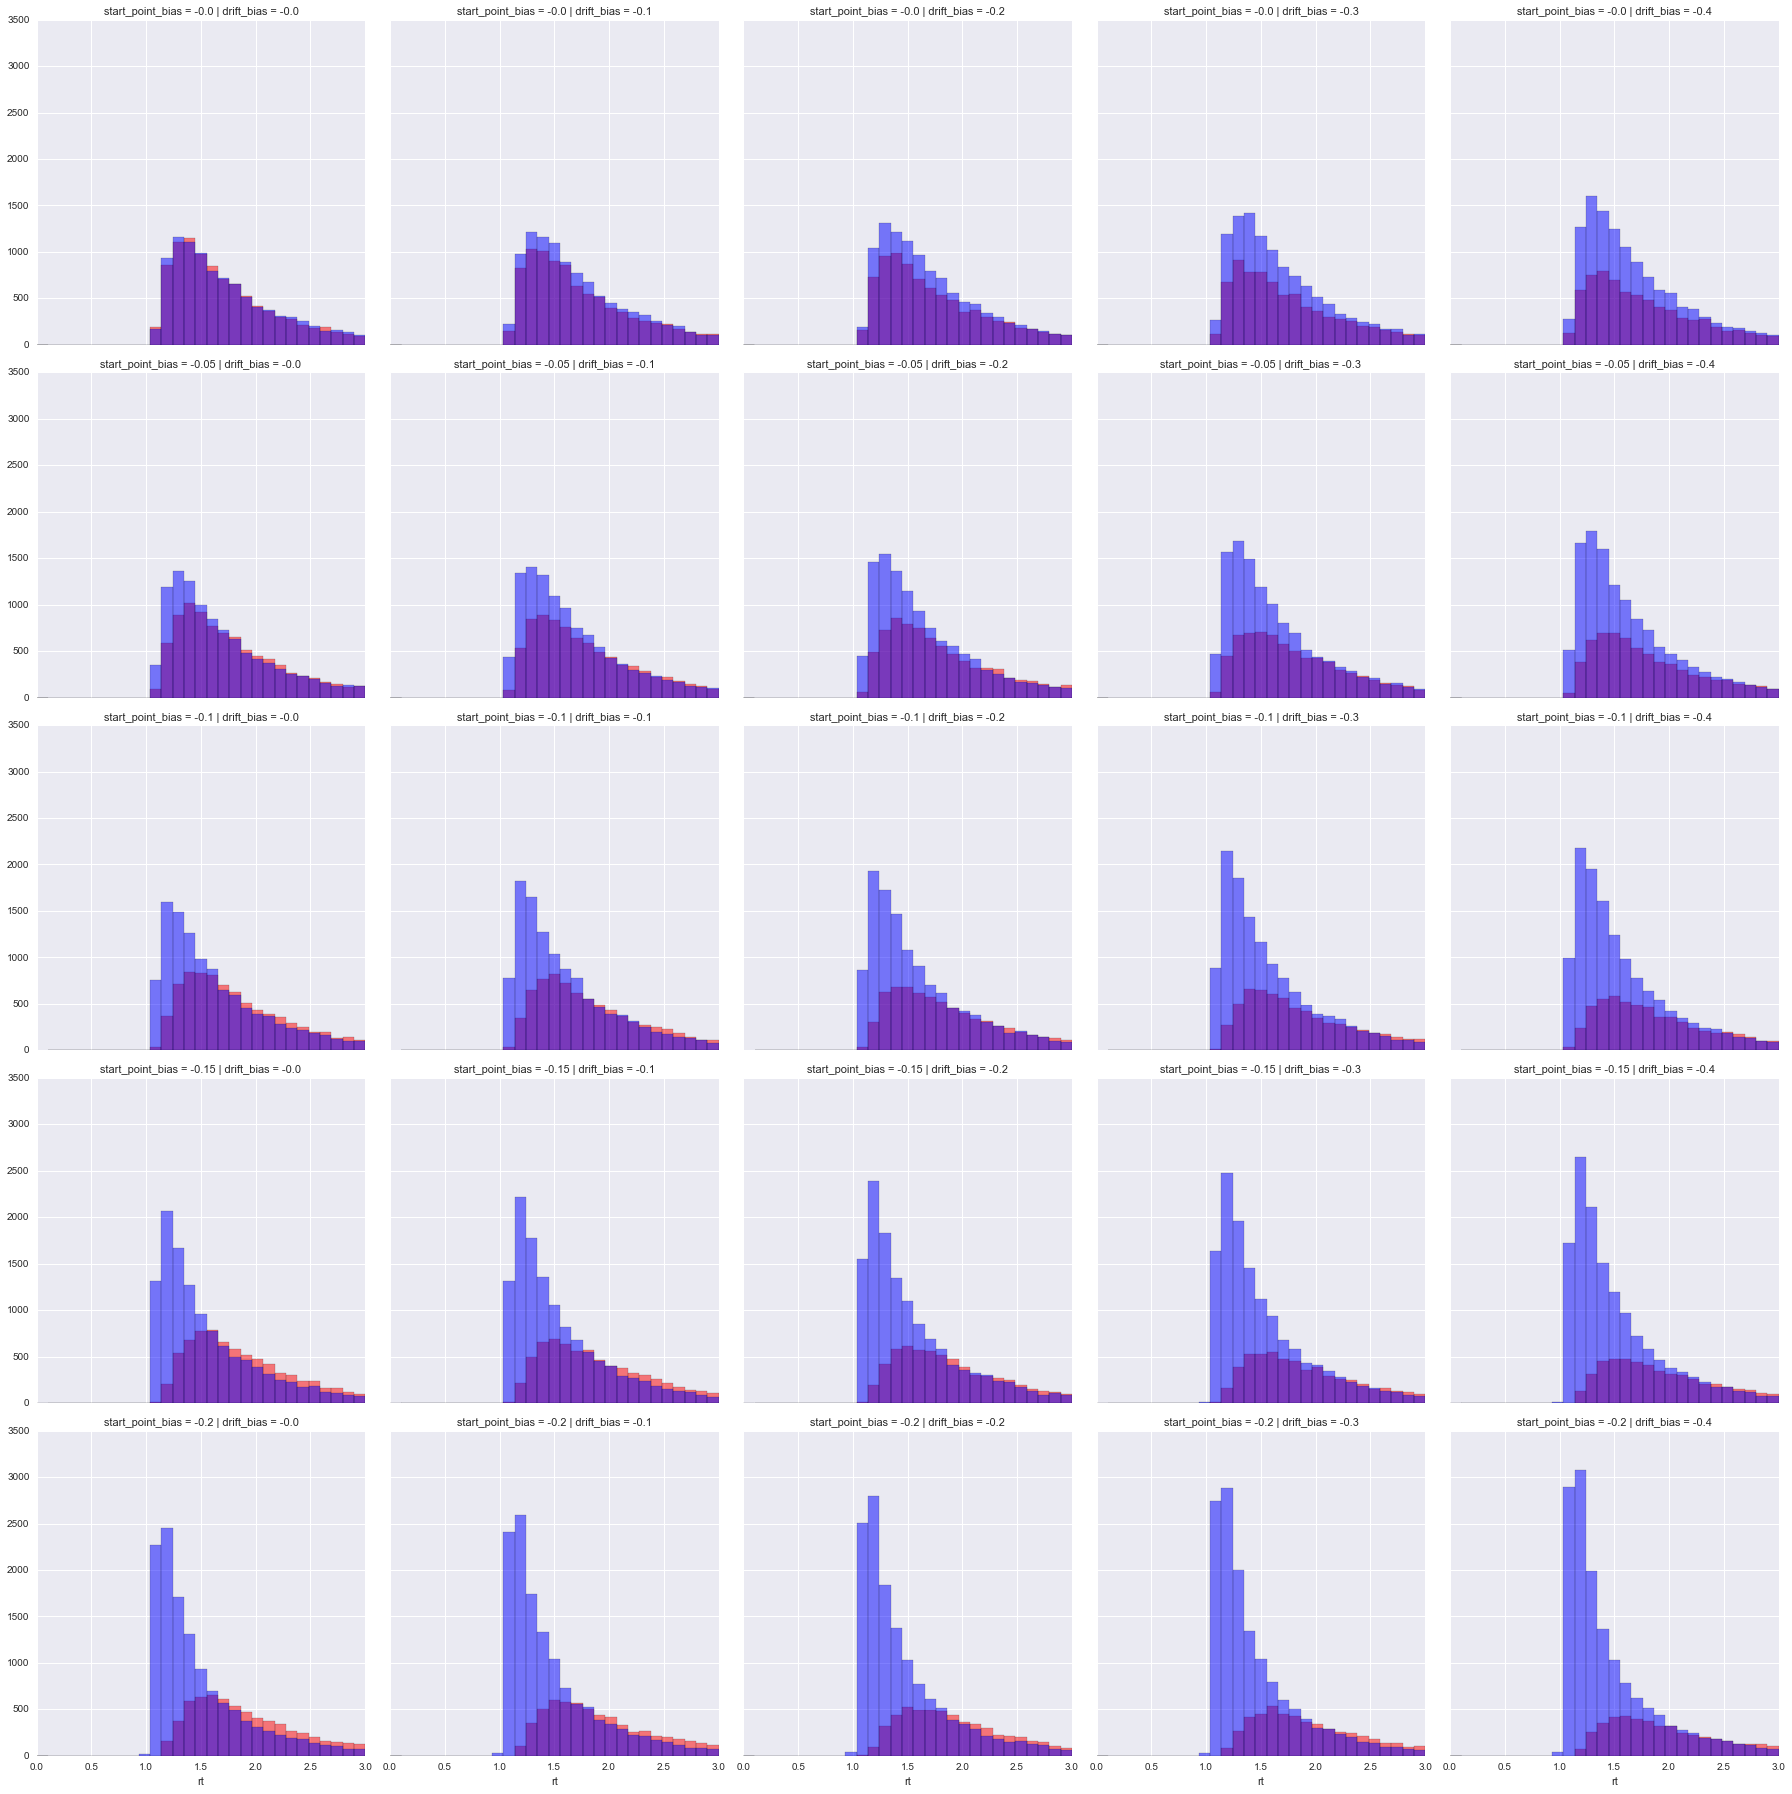

In [7]:
sns.set_palette(['red', 'blue'])
g = sns.FacetGrid(df, col="drift_bias",  row='start_point_bias',
                  hue="bias_response", size=5, 
                  hue_order=['biased_option', 'anti-biased option'],
                  col_order=sorted(df.drift_bias.unique()),                  
                  row_order=sorted(df.start_point_bias.unique()))
sns.set_style('whitegrid')
g.map(sns.distplot, 'rt', bins=np.linspace(0, 3, 30), norm_hist=False, kde=False, hist_kws={'alpha':0.5})
plt.xlim(0, 3)